In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import random
from tqdm import tqdm
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import pandas as pd 

## Fonctions

In [2]:
def display_images(images, n_row, n_col, title):
    fig, axes = plt.subplots(n_row, n_col, figsize=(1.5*n_col,2*n_row))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(title[i])
        ax.axis('off')
    plt.tight_layout(True)
    plt.show()
def lire_alpha_digit(data, L):
    """Extracts and binarizes specific characters from the dataset."""
    X=data['dat'][L[0]]
    for i in range(1,len(L)) :
        X_bis=data['dat'][L[i]]
        X=np.concatenate((X,X_bis),axis=0)
    n=X.shape[0]
    X=np.concatenate(X).reshape((n,320))
    return X

class RBM():
    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.a = np.zeros((p))
        self.b = np.zeros((q))
        self.W = np.random.normal(size = (p,q)) * np.sqrt(0.01)
    
    def entree_sortie(self, X):
        return 1 / (1 + np.exp(- self.b - X @ self.W))

    def sortie_entree(self, H):
        return 1 / (1 + np.exp( - self.a - H @ self.W.T))
    
    def train_RBM(self,  nb_epochs, lr, batch_size, X):
        nb_examples = X.shape[0]
        losses = []
        for e in tqdm(range(nb_epochs), "Going through epochs"):
            np.random.shuffle(X)
            for j in range(0, nb_examples ,batch_size):
                X_batch = X[ j : min(j + batch_size, nb_examples), :]
                X_batch_size = X_batch.shape[0]

                V0 = copy.deepcopy(X_batch)
                p_h_V0 = self.entree_sortie(V0)
                H0 = (np.random.rand(X_batch_size, self.q) < p_h_V0) * 1
                p_v_H0 = self.sortie_entree(H0)
                V1 = (np.random.rand(X_batch_size, self.p) < p_v_H0) * 1
                p_h_V1 = self.entree_sortie(V1)

                da = np.sum(V0-V1,axis=0)
                db = np.sum(p_h_V0- p_h_V1, axis=0)
                dW = V0.T@p_h_V0 - V1.T@p_h_V1

                self.a += lr * da
                self.b += lr * db
                self.W += lr * dW
                
            H = self.entree_sortie(X)
            X_rec = self.sortie_entree(H)
            loss = np.mean((X-X_rec)**2)
            losses.append(loss)
            if e%10 == 0:
              print("epoch " + str(e) + "/" + str(nb_epochs) +" - loss : " + str(loss))

        plt.plot(losses)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('Evolution of the loss through ' + str(nb_epochs) + ' epochs')
        plt.show()
        print(f"Final Loss: {losses[-1]}")

    def generate_images(self, nb_iter, nb_images, size_img):

        images = []
        for i in range(nb_images):
            v=(np.random.rand(self.p)<0.5)*1
            for j in range(nb_iter):
                h = (np.random.rand(self.q)<self.entree_sortie(v))*1
                v = (np.random.rand(self.p)<self.sortie_entree(h))*1
            v=v.reshape(size_img)
            images.append(v)

        for im in images:
            plt.imshow(im, cmap='gray')
            plt.show()
        return images

In [3]:
class DBN():
    def __init__(self, p, q, nb_layers):
        self.DBN = []
        for n in range(nb_layers):
            input_size = p if n == 0 else q
            self.DBN.append(RBM(p=input_size, q=q))
    def train_DBN(self, n_iter, lr, batch_size, X):
        for layer in self.DBN:
            layer.train_RBM(n_iter, lr, batch_size, X)
            #print(f"X.shape: {X.shape}, W.shape: {layer.W.shape}")
            X = layer.entree_sortie(X)
            #print(f"X.shape: {X.shape}, W.shape: {layer.W.shape}")
    def generate_image_DBN(self, nb_iter, nb_images, size_img):
        images = []
        v = (np.random.rand(nb_images, self.DBN[0].p) < 0.5) * 1  # Initialisation aléatoire des pixels

        for _ in range(nb_iter):
            # Passage ascendant (génération des représentations cachées)
            for layer in self.DBN:
                h = (np.random.rand(nb_images, layer.q) < layer.entree_sortie(v)) * 1
                v = h  # h devient la nouvelle entrée
            
            # Passage descendant (reconstruction des images)
            for layer in reversed(self.DBN):
                v = (np.random.rand(nb_images, layer.p) < layer.sortie_entree(h)) * 1
                h = v  # v devient la nouvelle entrée
        
        # Affichage des images sur une grille
        rows = math.ceil(math.sqrt(nb_images))
        cols = math.ceil(nb_images / rows)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = axes.flatten() if nb_images > 1 else [axes]
        
        for i, im in enumerate(v):
            im = im.reshape(size_img)
            images.append(im)
            axes[i].imshow(im, cmap='gray')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return images

In [4]:
class DNN():
    def __init__(self, p, q, nb_layers):
        self.DBN = DBN(p, q, nb_layers)
    def pretrain_DNN(self, n_iter, lr, batch_size, X):
        self.DBN.train_DBN(n_iter, lr, batch_size, X)
    def calcul_softmax(self, RBM, X):
        return np.exp(RBM.sortie_entree(X)) / np.sum(np.exp(RBM.sortie_entree(X)))
    def entree_sortie_reseau(self, X):
        outputs = []
        proba = []
        for layer in self.DBN.DBN:
            proba.append(DNN.calcul_softmax(layer, X))
            outputs.append(X)
        return outputs, proba
    def retropropagation(self, n_iter, lr, batch_size, X, Y):
        self.pretrain_DNN(n_iter, lr, batch_size, X)
        outputs, proba = self.entree_sortie_reseau(X)
        for i in range(n_iter):
            for j in range(0, X.shape[0], batch_size):
                X_batch = X[j:j+batch_size]
                Y_batch = Y[j:j+batch_size]
                for layer in self.DBN.DBN:
                    for k in range(len(X_batch)):
                        layer.a += lr * (Y_batch[k] - proba[k]) @ outputs[k]
                        layer.b += lr * (Y_batch[k] - proba[k])
                        layer.W += lr * (Y_batch[k] - proba[k]) @ outputs[k].T
                outputs, proba = self.entree_sortie_reseau(X)
    def test_DNN(self, X, Y):
        outputs, proba = self.entree_sortie_reseau(X)
        Y_pred = np.argmax(proba, axis=1)
        return np.mean(Y_pred == Y)
    
    

# Etude


Exemples d'images de la base de données :


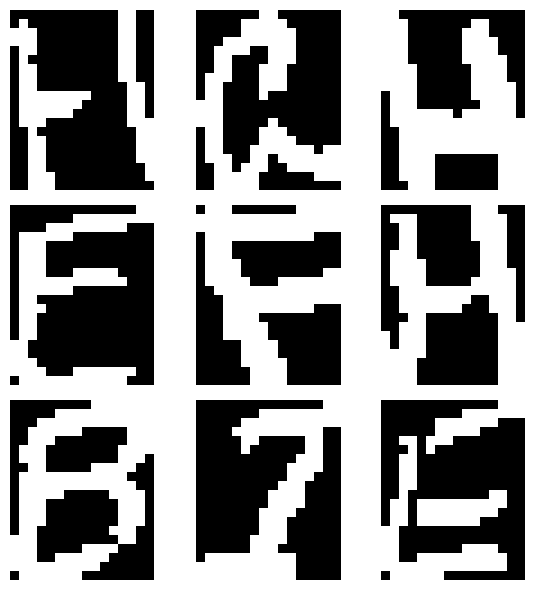


Test RBM avec q=50, n_characters=2

Entraînement du RBM...


Going through epochs:  24%|██▍       | 24/100 [00:00<00:00, 230.59it/s]

epoch 0/100 - loss : 0.1973315872890601
epoch 10/100 - loss : 0.12685575954818812
epoch 20/100 - loss : 0.10379698109957584
epoch 30/100 - loss : 0.09020140171643964
epoch 40/100 - loss : 0.08006544646375302


Going through epochs:  72%|███████▏  | 72/100 [00:00<00:00, 216.87it/s]

epoch 50/100 - loss : 0.07220413979030936
epoch 60/100 - loss : 0.06580608914757058
epoch 70/100 - loss : 0.060264892222552595
epoch 80/100 - loss : 0.055592292897986395
epoch 90/100 - loss : 0.051675531212210454


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 221.31it/s]


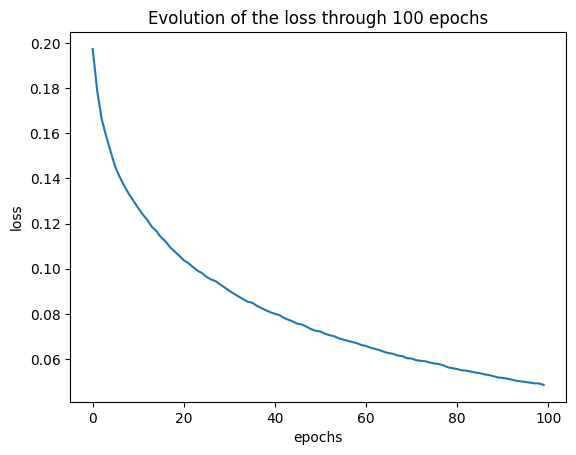

Final Loss: 0.04856598672126592


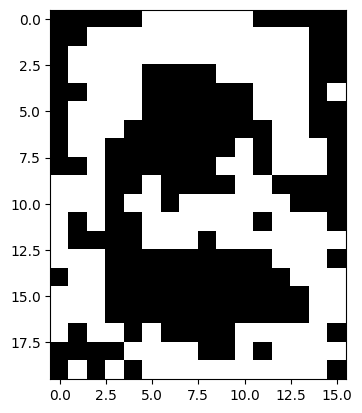

Image créée par le RBM


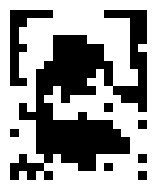


Test RBM avec q=50, n_characters=5

Entraînement du RBM...


Going through epochs:  11%|█         | 11/100 [00:00<00:00, 102.74it/s]

epoch 0/100 - loss : 0.18367923630400318
epoch 10/100 - loss : 0.10805435178202218
epoch 20/100 - loss : 0.09046137592600878


Going through epochs:  44%|████▍     | 44/100 [00:00<00:00, 106.11it/s]

epoch 30/100 - loss : 0.0797990081924907
epoch 40/100 - loss : 0.072616834829478
epoch 50/100 - loss : 0.06735748173308362


Going through epochs:  80%|████████  | 80/100 [00:00<00:00, 109.65it/s]

epoch 60/100 - loss : 0.06320066580870487
epoch 70/100 - loss : 0.06022590971314269
epoch 80/100 - loss : 0.05713388038390352


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 108.20it/s]


epoch 90/100 - loss : 0.05484086537615433


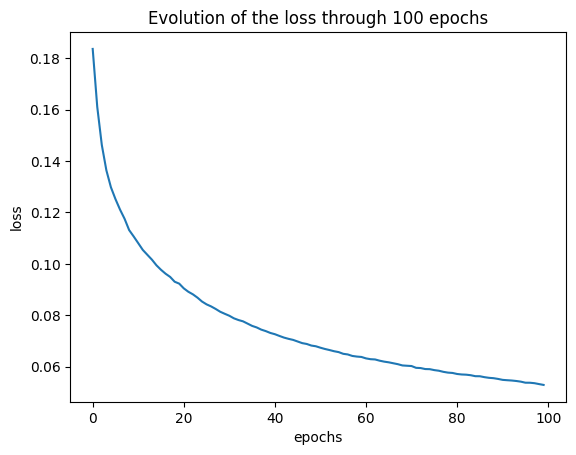

Final Loss: 0.05287151738457507


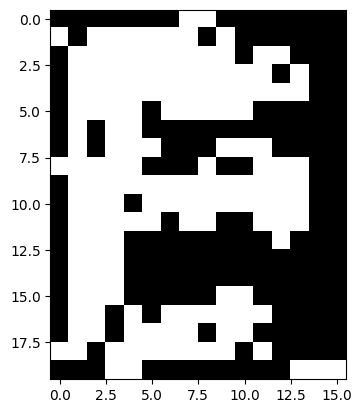

Image créée par le RBM


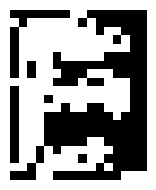


Test RBM avec q=50, n_characters=7

Entraînement du RBM...


Going through epochs:   9%|▉         | 9/100 [00:00<00:01, 81.52it/s]

epoch 0/100 - loss : 0.17882181768523087
epoch 10/100 - loss : 0.10399843952004001


Going through epochs:  37%|███▋      | 37/100 [00:00<00:00, 82.19it/s]

epoch 20/100 - loss : 0.08782186675825786
epoch 30/100 - loss : 0.07878185159933389


Going through epochs:  56%|█████▌    | 56/100 [00:00<00:00, 80.06it/s]

epoch 40/100 - loss : 0.07296408526334237
epoch 50/100 - loss : 0.0689646416943988


Going through epochs:  74%|███████▍  | 74/100 [00:00<00:00, 83.34it/s]

epoch 60/100 - loss : 0.06590917032737284
epoch 70/100 - loss : 0.06360995498375036


Going through epochs:  92%|█████████▏| 92/100 [00:01<00:00, 84.05it/s]

epoch 80/100 - loss : 0.06124222179668853
epoch 90/100 - loss : 0.05996022942054889


Going through epochs: 100%|██████████| 100/100 [00:01<00:00, 82.26it/s]


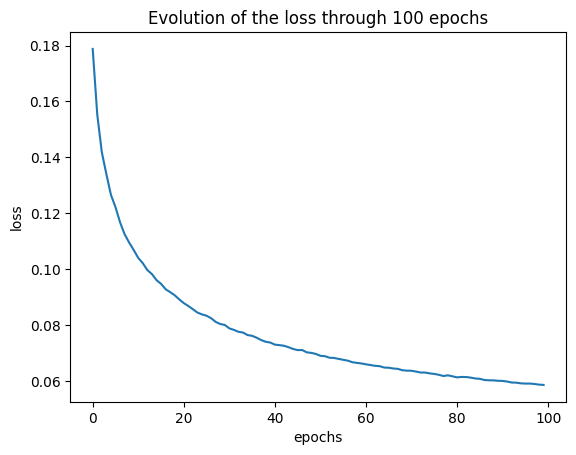

Final Loss: 0.05853791888637667


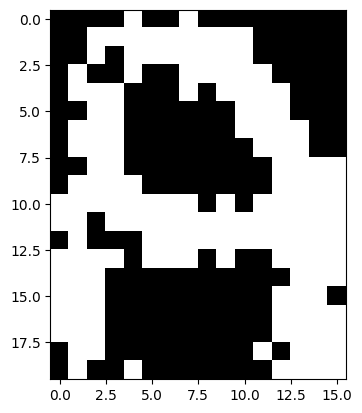

Image créée par le RBM


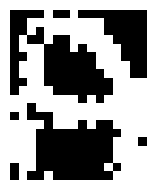


Test RBM avec q=100, n_characters=2

Entraînement du RBM...


Going through epochs:   6%|▌         | 6/100 [00:00<00:01, 51.51it/s]

epoch 0/100 - loss : 0.19231372675816047


Going through epochs:  17%|█▋        | 17/100 [00:00<00:01, 47.58it/s]

epoch 10/100 - loss : 0.10749207164470308


Going through epochs:  27%|██▋       | 27/100 [00:00<00:01, 43.95it/s]

epoch 20/100 - loss : 0.0772395985601672


Going through epochs:  32%|███▏      | 32/100 [00:00<00:01, 41.04it/s]

epoch 30/100 - loss : 0.05754014932487458


Going through epochs:  45%|████▌     | 45/100 [00:01<00:01, 31.48it/s]

epoch 40/100 - loss : 0.04585392644987641


Going through epochs:  53%|█████▎    | 53/100 [00:01<00:01, 29.96it/s]

epoch 50/100 - loss : 0.03756844395669371


Going through epochs:  66%|██████▌   | 66/100 [00:01<00:01, 27.81it/s]

epoch 60/100 - loss : 0.030395593203435097


Going through epochs:  73%|███████▎  | 73/100 [00:02<00:00, 27.11it/s]

epoch 70/100 - loss : 0.02525123251492009


Going through epochs:  85%|████████▌ | 85/100 [00:02<00:00, 25.02it/s]

epoch 80/100 - loss : 0.021577681209524243


Going through epochs:  94%|█████████▍| 94/100 [00:03<00:00, 24.65it/s]

epoch 90/100 - loss : 0.018420298222594073


Going through epochs: 100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


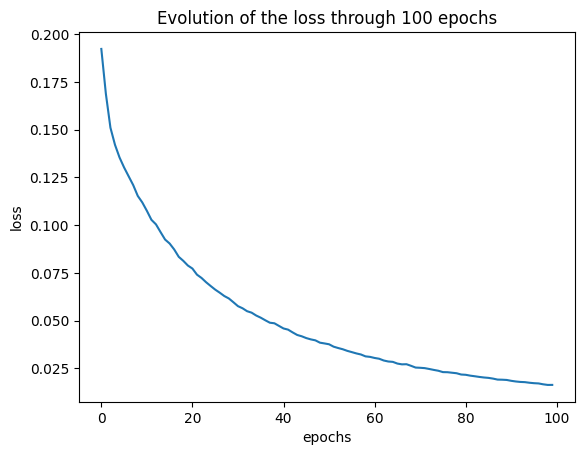

Final Loss: 0.016281641926142107


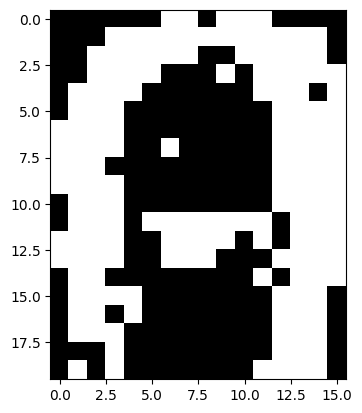

Image créée par le RBM


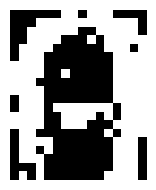


Test RBM avec q=100, n_characters=5

Entraînement du RBM...


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.17231282214409532


Going through epochs:  13%|█▎        | 13/100 [00:01<00:07, 11.52it/s]

epoch 10/100 - loss : 0.08739318614390446


Going through epochs:  21%|██        | 21/100 [00:01<00:07, 10.63it/s]

epoch 20/100 - loss : 0.06363257178929654


Going through epochs:  33%|███▎      | 33/100 [00:02<00:06, 10.15it/s]

epoch 30/100 - loss : 0.05062745008905864


Going through epochs:  43%|████▎     | 43/100 [00:03<00:05, 10.28it/s]

epoch 40/100 - loss : 0.04265208190236636


Going through epochs:  53%|█████▎    | 53/100 [00:04<00:04, 10.49it/s]

epoch 50/100 - loss : 0.03678550860513119


Going through epochs:  63%|██████▎   | 63/100 [00:05<00:03, 11.52it/s]

epoch 60/100 - loss : 0.03176199257178729


Going through epochs:  71%|███████   | 71/100 [00:06<00:02, 11.00it/s]

epoch 70/100 - loss : 0.0281780558704517


Going through epochs:  83%|████████▎ | 83/100 [00:07<00:01, 10.25it/s]

epoch 80/100 - loss : 0.025385241642255963


Going through epochs:  91%|█████████ | 91/100 [00:08<00:00, 10.60it/s]

epoch 90/100 - loss : 0.022993993315140945


Going through epochs: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


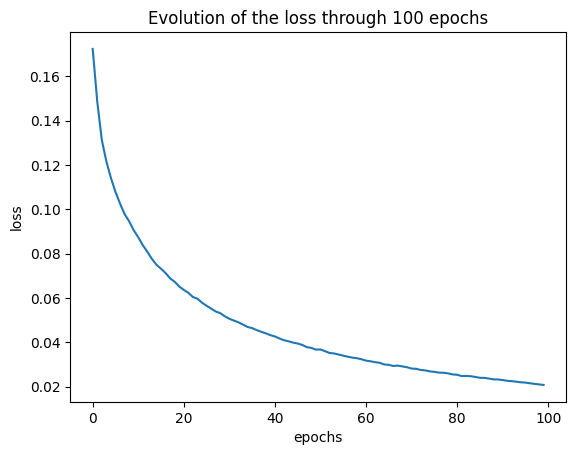

Final Loss: 0.020794523230402078


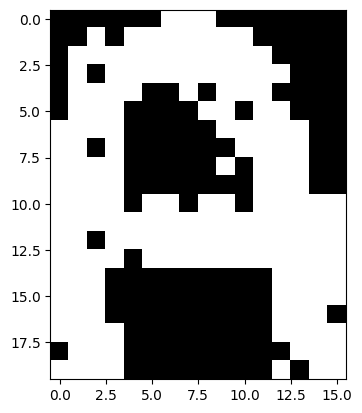

Image créée par le RBM


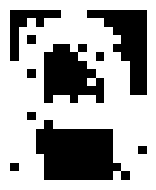


Test RBM avec q=100, n_characters=7

Entraînement du RBM...


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.1663687256976117


Going through epochs:  12%|█▏        | 12/100 [00:01<00:11,  7.71it/s]

epoch 10/100 - loss : 0.08429724576651126


Going through epochs:  22%|██▏       | 22/100 [00:02<00:10,  7.57it/s]

epoch 20/100 - loss : 0.06255815945068872


Going through epochs:  32%|███▏      | 32/100 [00:04<00:10,  6.55it/s]

epoch 30/100 - loss : 0.05118080053130402


Going through epochs:  43%|████▎     | 43/100 [00:05<00:06,  9.15it/s]

epoch 40/100 - loss : 0.04334548522361159


Going through epochs:  51%|█████     | 51/100 [00:06<00:04, 10.18it/s]

epoch 50/100 - loss : 0.037890755119599356


Going through epochs:  62%|██████▏   | 62/100 [00:07<00:03, 10.08it/s]

epoch 60/100 - loss : 0.0336536990555491


Going through epochs:  72%|███████▏  | 72/100 [00:08<00:02,  9.53it/s]

epoch 70/100 - loss : 0.03034285379010475


Going through epochs:  82%|████████▏ | 82/100 [00:09<00:01,  9.16it/s]

epoch 80/100 - loss : 0.027266550703230363


Going through epochs:  92%|█████████▏| 92/100 [00:10<00:01,  7.81it/s]

epoch 90/100 - loss : 0.024963863300804648


Going through epochs: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


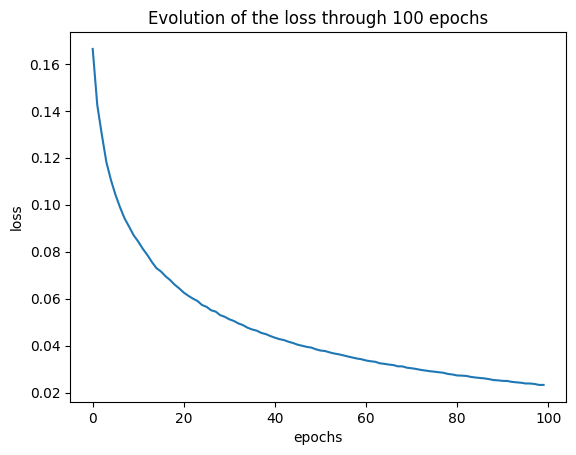

Final Loss: 0.023236608957316843


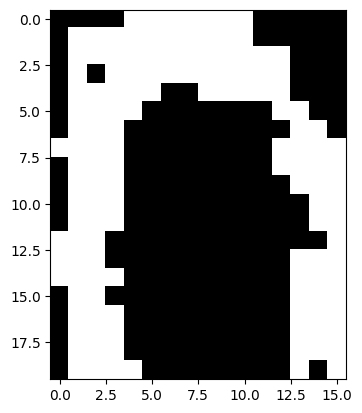

Image créée par le RBM


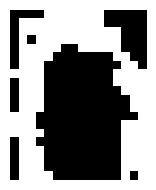


Test RBM avec q=400, n_characters=2

Entraînement du RBM...


Going through epochs:   3%|▎         | 3/100 [00:00<00:04, 23.69it/s]

epoch 0/100 - loss : 0.17912385614482362


Going through epochs:  12%|█▏        | 12/100 [00:00<00:04, 20.14it/s]

epoch 10/100 - loss : 0.07087154935446736


Going through epochs:  24%|██▍       | 24/100 [00:01<00:03, 20.95it/s]

epoch 20/100 - loss : 0.0333127344534726


Going through epochs:  33%|███▎      | 33/100 [00:01<00:03, 20.59it/s]

epoch 30/100 - loss : 0.016438217877536368


Going through epochs:  45%|████▌     | 45/100 [00:02<00:02, 21.47it/s]

epoch 40/100 - loss : 0.00874190780003619


Going through epochs:  54%|█████▍    | 54/100 [00:02<00:02, 21.34it/s]

epoch 50/100 - loss : 0.005290591677112664


Going through epochs:  63%|██████▎   | 63/100 [00:02<00:01, 21.40it/s]

epoch 60/100 - loss : 0.003208327393650709


Going through epochs:  72%|███████▏  | 72/100 [00:03<00:01, 22.00it/s]

epoch 70/100 - loss : 0.002176921130414646


Going through epochs:  84%|████████▍ | 84/100 [00:03<00:00, 20.94it/s]

epoch 80/100 - loss : 0.001529084159775623


Going through epochs:  93%|█████████▎| 93/100 [00:04<00:00, 21.23it/s]

epoch 90/100 - loss : 0.0010925354900281992


Going through epochs: 100%|██████████| 100/100 [00:04<00:00, 21.28it/s]


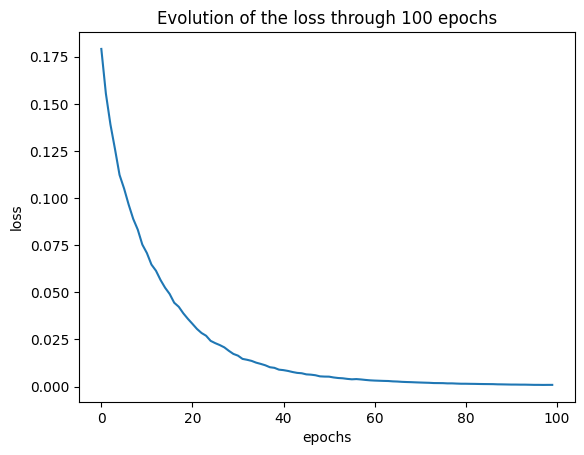

Final Loss: 0.0009290737730472288


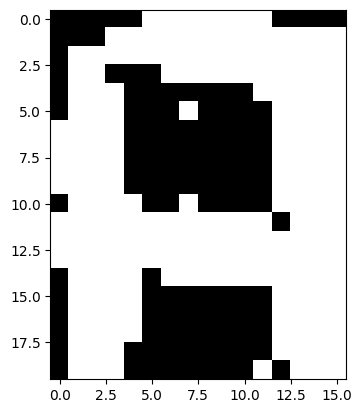

Image créée par le RBM


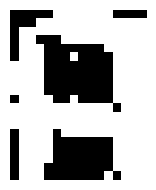


Test RBM avec q=400, n_characters=5

Entraînement du RBM...


Going through epochs:   1%|          | 1/100 [00:00<00:11,  9.00it/s]

epoch 0/100 - loss : 0.14813689415971934


Going through epochs:  12%|█▏        | 12/100 [00:01<00:10,  8.29it/s]

epoch 10/100 - loss : 0.05115832431925743


Going through epochs:  22%|██▏       | 22/100 [00:02<00:09,  8.21it/s]

epoch 20/100 - loss : 0.026312076070284733


Going through epochs:  32%|███▏      | 32/100 [00:03<00:07,  8.57it/s]

epoch 30/100 - loss : 0.01366287098883952


Going through epochs:  42%|████▏     | 42/100 [00:04<00:07,  8.06it/s]

epoch 40/100 - loss : 0.007768891384825995


Going through epochs:  52%|█████▏    | 52/100 [00:06<00:05,  8.63it/s]

epoch 50/100 - loss : 0.004771312235033119


Going through epochs:  62%|██████▏   | 62/100 [00:07<00:04,  8.41it/s]

epoch 60/100 - loss : 0.0029978727706023093


Going through epochs:  72%|███████▏  | 72/100 [00:08<00:03,  9.11it/s]

epoch 70/100 - loss : 0.002003857004247554


Going through epochs:  82%|████████▏ | 82/100 [00:09<00:01,  9.22it/s]

epoch 80/100 - loss : 0.0013927687239222288


Going through epochs:  92%|█████████▏| 92/100 [00:10<00:00,  9.18it/s]

epoch 90/100 - loss : 0.0010965335547445552


Going through epochs: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


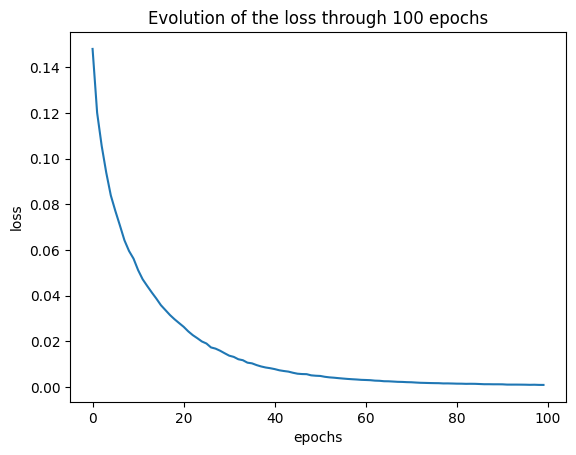

Final Loss: 0.0008390395793145637


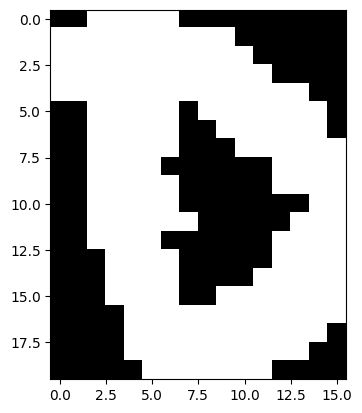

Image créée par le RBM


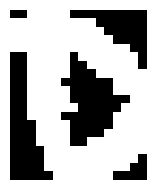


Test RBM avec q=400, n_characters=7

Entraînement du RBM...


Going through epochs:   1%|          | 1/100 [00:00<00:13,  7.53it/s]

epoch 0/100 - loss : 0.1474436263636627


Going through epochs:  12%|█▏        | 12/100 [00:01<00:13,  6.33it/s]

epoch 10/100 - loss : 0.04746546563457259


Going through epochs:  22%|██▏       | 22/100 [00:03<00:11,  6.58it/s]

epoch 20/100 - loss : 0.023425014733450045


Going through epochs:  32%|███▏      | 32/100 [00:04<00:09,  6.86it/s]

epoch 30/100 - loss : 0.012681871035725894


Going through epochs:  42%|████▏     | 42/100 [00:06<00:09,  6.13it/s]

epoch 40/100 - loss : 0.0071692064121208305


Going through epochs:  52%|█████▏    | 52/100 [00:08<00:08,  5.98it/s]

epoch 50/100 - loss : 0.004300935314048901


Going through epochs:  62%|██████▏   | 62/100 [00:09<00:06,  6.21it/s]

epoch 60/100 - loss : 0.0029177335551899483


Going through epochs:  72%|███████▏  | 72/100 [00:11<00:04,  6.19it/s]

epoch 70/100 - loss : 0.0019487748010050066


Going through epochs:  82%|████████▏ | 82/100 [00:12<00:02,  6.39it/s]

epoch 80/100 - loss : 0.0013286877065741382


Going through epochs:  92%|█████████▏| 92/100 [00:14<00:01,  6.32it/s]

epoch 90/100 - loss : 0.0010552439006383952


Going through epochs: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


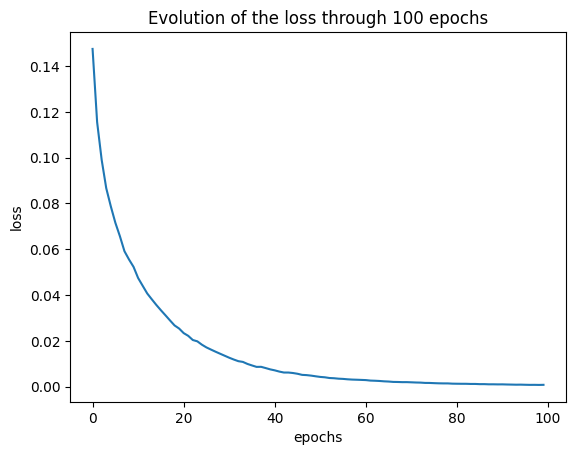

Final Loss: 0.0008516377367101133


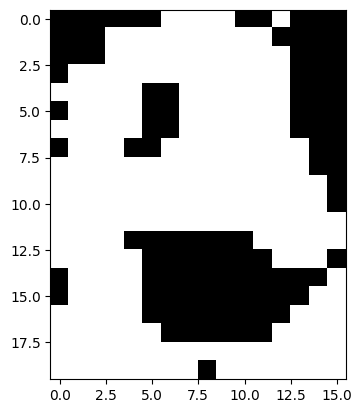

Image créée par le RBM


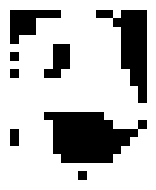


Test DBN avec q=50, n_layers=2, n_characters=3

Entraînement du DBN...


Going through epochs:  16%|█▌        | 16/100 [00:00<00:00, 145.98it/s]

epoch 0/100 - loss : 0.1814566682250866
epoch 10/100 - loss : 0.11392293967712604
epoch 20/100 - loss : 0.09652170430460778


Going through epochs:  48%|████▊     | 48/100 [00:00<00:00, 152.40it/s]

epoch 30/100 - loss : 0.08564364439704787
epoch 40/100 - loss : 0.0778105509818011
epoch 50/100 - loss : 0.07114138401136866
epoch 60/100 - loss : 0.06574242303595906


Going through epochs:  80%|████████  | 80/100 [00:00<00:00, 153.24it/s]

epoch 70/100 - loss : 0.06144765267924816
epoch 80/100 - loss : 0.05792809042641259
epoch 90/100 - loss : 0.05470720653428866


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 152.73it/s]


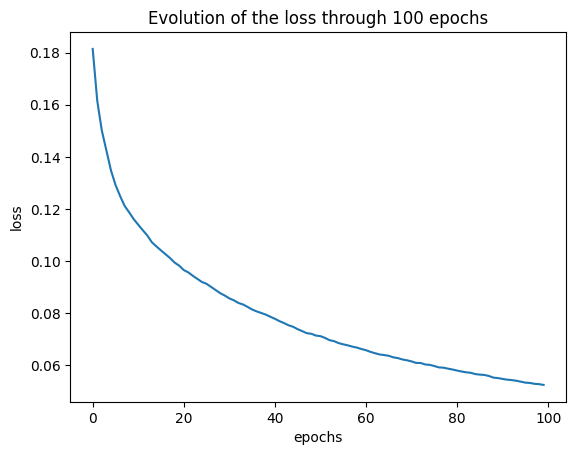

Final Loss: 0.05240891044619143


Going through epochs:  36%|███▌      | 36/100 [00:00<00:00, 353.73it/s]

epoch 0/100 - loss : 0.1957377114583985
epoch 10/100 - loss : 0.08649463956069904
epoch 20/100 - loss : 0.06725199365878853
epoch 30/100 - loss : 0.057986263064163795
epoch 40/100 - loss : 0.049800275128564615
epoch 50/100 - loss : 0.04462613837789165
epoch 60/100 - loss : 0.0399230026926329


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 342.88it/s]

epoch 70/100 - loss : 0.03589909231237657
epoch 80/100 - loss : 0.03330125085780684
epoch 90/100 - loss : 0.030252196165861056


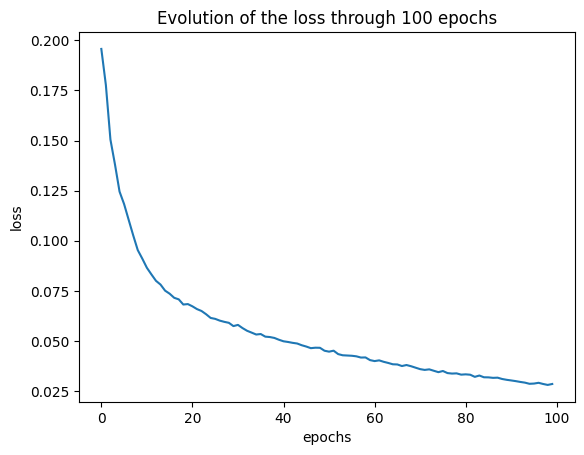

Final Loss: 0.028489777074169293


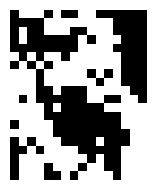

Image créée par le DBN


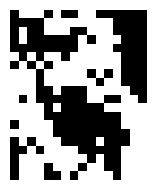


Test DBN avec q=50, n_layers=3, n_characters=3

Entraînement du DBN...


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.18178812967343838


Going through epochs:  14%|█▍        | 14/100 [00:00<00:00, 138.55it/s]

epoch 10/100 - loss : 0.113014314421778
epoch 20/100 - loss : 0.09589996683767338


Going through epochs:  30%|███       | 30/100 [00:00<00:00, 150.08it/s]

epoch 30/100 - loss : 0.08512524579360654
epoch 40/100 - loss : 0.07750821365020351


Going through epochs:  46%|████▌     | 46/100 [00:00<00:00, 144.48it/s]

epoch 50/100 - loss : 0.07114732032955494


Going through epochs:  78%|███████▊  | 78/100 [00:00<00:00, 151.06it/s]

epoch 60/100 - loss : 0.06628994701129082
epoch 70/100 - loss : 0.06186312909282642
epoch 80/100 - loss : 0.05852932287946296
epoch 90/100 - loss : 0.05589324151657037


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 144.07it/s]


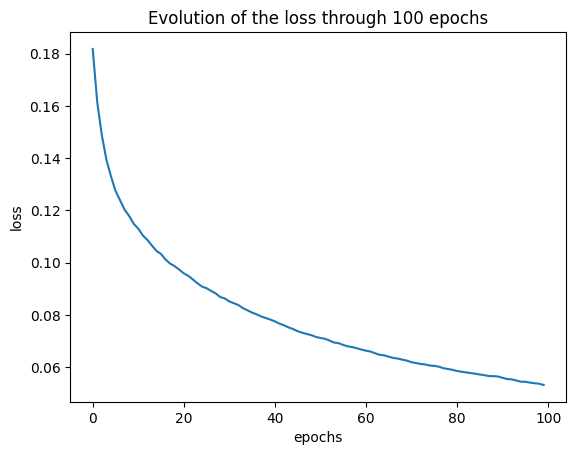

Final Loss: 0.05318031072736839


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.1929476109058402
epoch 10/100 - loss : 0.08590698959678165


Going through epochs:  38%|███▊      | 38/100 [00:00<00:00, 350.83it/s]

epoch 20/100 - loss : 0.06619610607758346
epoch 30/100 - loss : 0.057647027670164414
epoch 40/100 - loss : 0.04883843693092425
epoch 50/100 - loss : 0.04245467402728401
epoch 60/100 - loss : 0.03801707840702285


Going through epochs:  79%|███████▉  | 79/100 [00:00<00:00, 367.66it/s]

epoch 70/100 - loss : 0.03416004510855604
epoch 80/100 - loss : 0.031223235047285882
epoch 90/100 - loss : 0.02878217158856137


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 364.54it/s]


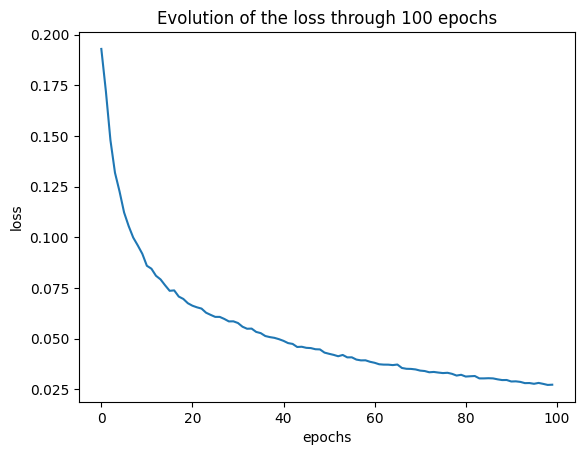

Final Loss: 0.02719598403980227


Going through epochs:  39%|███▉      | 39/100 [00:00<00:00, 365.23it/s]

epoch 0/100 - loss : 0.15543234300782283
epoch 10/100 - loss : 0.04292678829802988
epoch 20/100 - loss : 0.02762965417761578
epoch 30/100 - loss : 0.02335108966825278
epoch 40/100 - loss : 0.018995795760764184
epoch 50/100 - loss : 0.016290646710524548
epoch 60/100 - loss : 0.014239904032451053
epoch 70/100 - loss : 0.011345886640974686


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 373.13it/s]


epoch 80/100 - loss : 0.011089517027232307
epoch 90/100 - loss : 0.010391666348818333


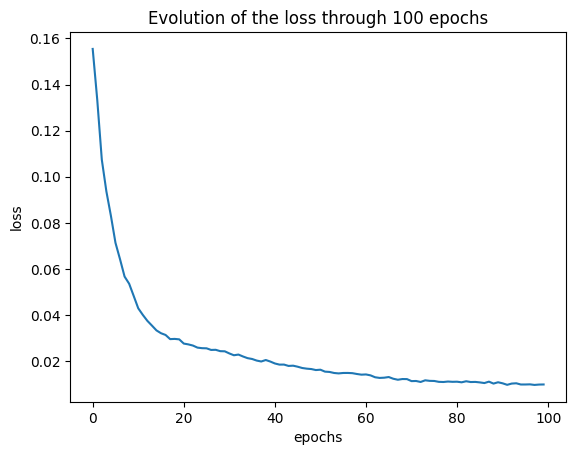

Final Loss: 0.009887073674984698


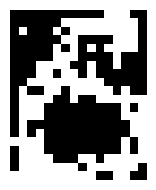

Image créée par le DBN


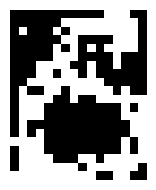


Test DBN avec q=50, n_layers=4, n_characters=3

Entraînement du DBN...


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.17644425525189286


Going through epochs:  14%|█▍        | 14/100 [00:00<00:00, 130.13it/s]

epoch 10/100 - loss : 0.11120643297676394
epoch 20/100 - loss : 0.09557058388793199


Going through epochs:  31%|███       | 31/100 [00:00<00:00, 149.39it/s]

epoch 30/100 - loss : 0.08496466870682728
epoch 40/100 - loss : 0.07737437509393363


Going through epochs:  66%|██████▌   | 66/100 [00:00<00:00, 162.06it/s]

epoch 50/100 - loss : 0.07124600939676873
epoch 60/100 - loss : 0.06599432341640776
epoch 70/100 - loss : 0.06198287551470464


Going through epochs:  83%|████████▎ | 83/100 [00:00<00:00, 147.13it/s]

epoch 80/100 - loss : 0.058438694075605306
epoch 90/100 - loss : 0.05536551124777542


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 153.45it/s]


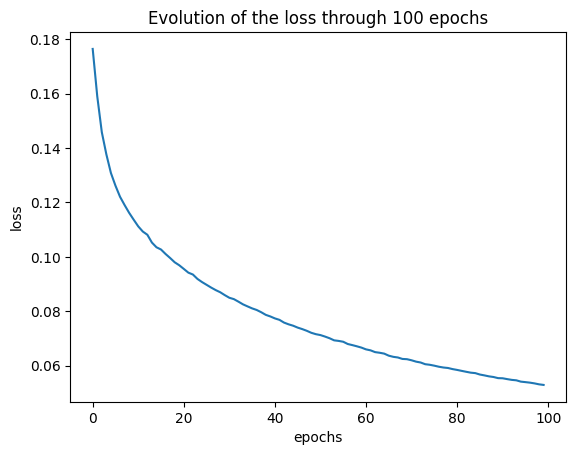

Final Loss: 0.05292152809491728


Going through epochs:  35%|███▌      | 35/100 [00:00<00:00, 318.13it/s]

epoch 0/100 - loss : 0.19784581741329105
epoch 10/100 - loss : 0.08747015532446374
epoch 20/100 - loss : 0.06721804022839929
epoch 30/100 - loss : 0.057254865129727814
epoch 40/100 - loss : 0.050347320730986814
epoch 50/100 - loss : 0.04524708826039861
epoch 60/100 - loss : 0.039176460849618906


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 319.78it/s]

epoch 70/100 - loss : 0.036436713770653176
epoch 80/100 - loss : 0.032970072476992886
epoch 90/100 - loss : 0.030390397069096617


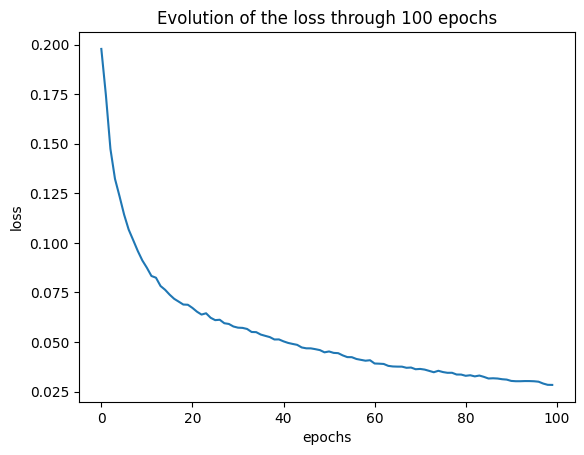

Final Loss: 0.028370377202103163


Going through epochs:  72%|███████▏  | 72/100 [00:00<00:00, 348.86it/s]

epoch 0/100 - loss : 0.15679586204391374
epoch 10/100 - loss : 0.040988340389594334
epoch 20/100 - loss : 0.02766798877306643
epoch 30/100 - loss : 0.023032193678472593
epoch 40/100 - loss : 0.020339521209982142
epoch 50/100 - loss : 0.017969199774358662
epoch 60/100 - loss : 0.014980078625015587
epoch 70/100 - loss : 0.01360217541011054


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 315.98it/s]

epoch 80/100 - loss : 0.01253539161417261
epoch 90/100 - loss : 0.011120710122835635


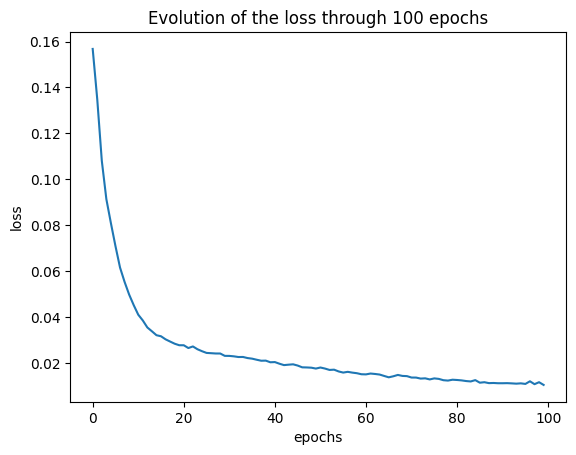

Final Loss: 0.010386872828923897


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.14057385010319928


Going through epochs:  31%|███       | 31/100 [00:00<00:00, 308.16it/s]

epoch 10/100 - loss : 0.02760163133024997
epoch 20/100 - loss : 0.014458013670631986
epoch 30/100 - loss : 0.01102970177348792
epoch 40/100 - loss : 0.009524074996016714
epoch 50/100 - loss : 0.008645952944120665
epoch 60/100 - loss : 0.007371064755108921


Going through epochs:  65%|██████▌   | 65/100 [00:00<00:00, 323.18it/s]

epoch 70/100 - loss : 0.007596141157251486


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 313.06it/s]


epoch 80/100 - loss : 0.006815258310305772
epoch 90/100 - loss : 0.006207004027002637


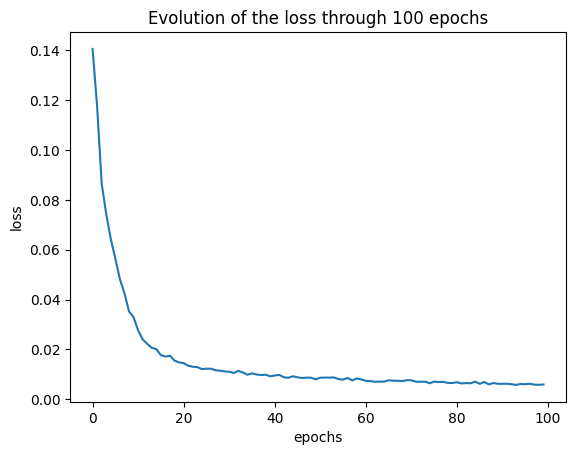

Final Loss: 0.005909983720556202


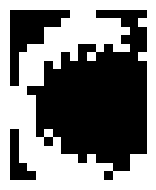

Image créée par le DBN


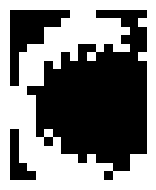


Test DBN avec q=100, n_layers=2, n_characters=3

Entraînement du DBN...


Going through epochs:   3%|▎         | 3/100 [00:00<00:04, 20.34it/s]

epoch 0/100 - loss : 0.16832724104103658


Going through epochs:  14%|█▍        | 14/100 [00:00<00:04, 18.57it/s]

epoch 10/100 - loss : 0.0926458782162278


Going through epochs:  24%|██▍       | 24/100 [00:01<00:04, 16.69it/s]

epoch 20/100 - loss : 0.0705121834597


Going through epochs:  32%|███▏      | 32/100 [00:01<00:04, 15.83it/s]

epoch 30/100 - loss : 0.05630791560508899


Going through epochs:  42%|████▏     | 42/100 [00:02<00:03, 16.30it/s]

epoch 40/100 - loss : 0.046052728332974864


Going through epochs:  54%|█████▍    | 54/100 [00:03<00:02, 15.52it/s]

epoch 50/100 - loss : 0.038428188221311346


Going through epochs:  62%|██████▏   | 62/100 [00:03<00:02, 15.28it/s]

epoch 60/100 - loss : 0.0327842795116938


Going through epochs:  74%|███████▍  | 74/100 [00:04<00:01, 15.25it/s]

epoch 70/100 - loss : 0.02797925541430334


Going through epochs:  82%|████████▏ | 82/100 [00:05<00:01, 15.25it/s]

epoch 80/100 - loss : 0.024700730968770113


Going through epochs:  92%|█████████▏| 92/100 [00:05<00:00, 14.74it/s]

epoch 90/100 - loss : 0.021696812120223122


Going through epochs: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


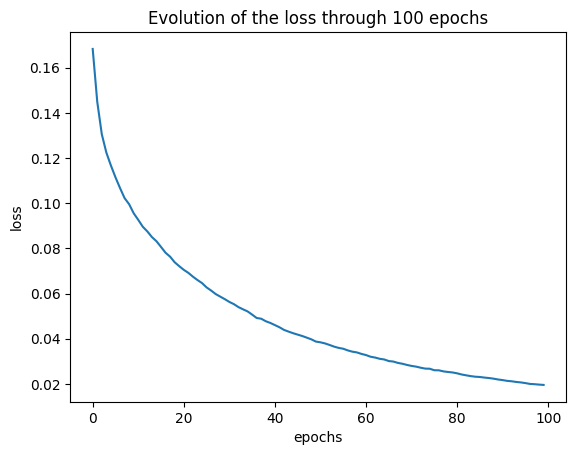

Final Loss: 0.019562087627302965


Going through epochs:  14%|█▍        | 14/100 [00:00<00:00, 129.50it/s]

epoch 0/100 - loss : 0.1606702036046024
epoch 10/100 - loss : 0.06859082368067577
epoch 20/100 - loss : 0.052006508542052576
epoch 30/100 - loss : 0.042368398239526955


Going through epochs:  75%|███████▌  | 75/100 [00:00<00:00, 184.01it/s]

epoch 40/100 - loss : 0.03431116783509667
epoch 50/100 - loss : 0.028397376936401666
epoch 60/100 - loss : 0.024460737891410584
epoch 70/100 - loss : 0.020200855042662835


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 178.58it/s]


epoch 80/100 - loss : 0.017673518773399646
epoch 90/100 - loss : 0.015066647559669893


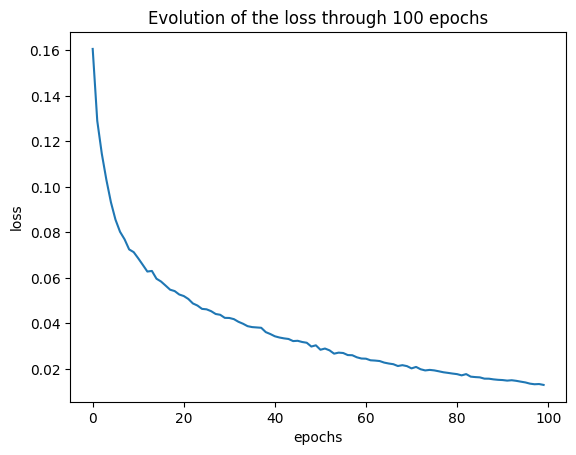

Final Loss: 0.012929195984672761


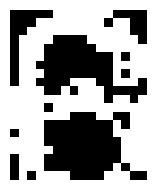

Image créée par le DBN


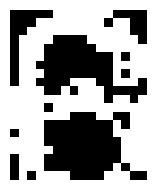


Test DBN avec q=100, n_layers=3, n_characters=3

Entraînement du DBN...


Going through epochs:   3%|▎         | 3/100 [00:00<00:04, 23.12it/s]

epoch 0/100 - loss : 0.17009910844541173


Going through epochs:  15%|█▌        | 15/100 [00:00<00:03, 21.92it/s]

epoch 10/100 - loss : 0.09501067459945559


Going through epochs:  24%|██▍       | 24/100 [00:01<00:03, 22.62it/s]

epoch 20/100 - loss : 0.07164663459993313


Going through epochs:  33%|███▎      | 33/100 [00:01<00:03, 17.91it/s]

epoch 30/100 - loss : 0.057375004523410676


Going through epochs:  43%|████▎     | 43/100 [00:02<00:03, 15.45it/s]

epoch 40/100 - loss : 0.047368210722791654


Going through epochs:  53%|█████▎    | 53/100 [00:02<00:03, 15.32it/s]

epoch 50/100 - loss : 0.03942102646042739


Going through epochs:  62%|██████▏   | 62/100 [00:03<00:02, 16.29it/s]

epoch 60/100 - loss : 0.033621675976449085


Going through epochs:  74%|███████▍  | 74/100 [00:04<00:01, 15.89it/s]

epoch 70/100 - loss : 0.028856253380824516


Going through epochs:  82%|████████▏ | 82/100 [00:04<00:01, 16.16it/s]

epoch 80/100 - loss : 0.025242518773955735


Going through epochs:  94%|█████████▍| 94/100 [00:05<00:00, 15.88it/s]

epoch 90/100 - loss : 0.02207345500493629


Going through epochs: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


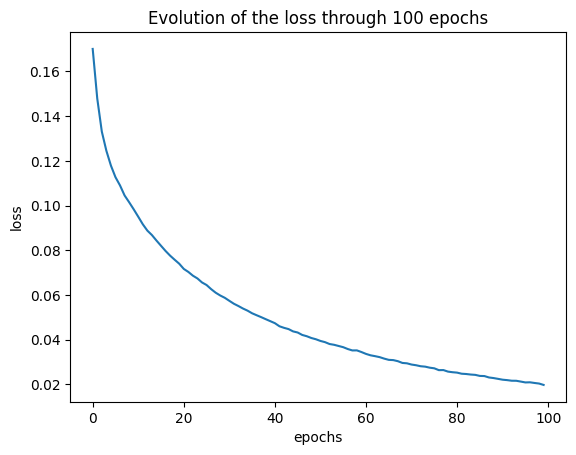

Final Loss: 0.019737079571469238


Going through epochs:  20%|██        | 20/100 [00:00<00:00, 199.94it/s]

epoch 0/100 - loss : 0.16717775493298156
epoch 10/100 - loss : 0.07041453918946487
epoch 20/100 - loss : 0.052212809126072436
epoch 30/100 - loss : 0.041602121931917556


Going through epochs:  82%|████████▏ | 82/100 [00:00<00:00, 201.86it/s]

epoch 40/100 - loss : 0.03446144798698827
epoch 50/100 - loss : 0.028603311203775884
epoch 60/100 - loss : 0.023566088577721328
epoch 70/100 - loss : 0.019849922349468953
epoch 80/100 - loss : 0.016301261860071345


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 191.24it/s]


epoch 90/100 - loss : 0.014060271119412437


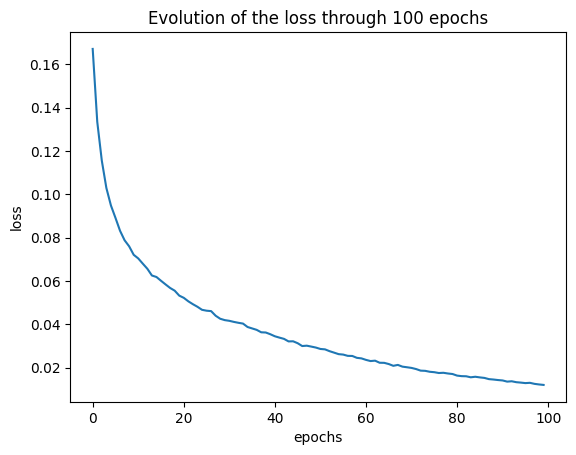

Final Loss: 0.011997279608522805


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.14350832767414773


Going through epochs:  21%|██        | 21/100 [00:00<00:00, 205.53it/s]

epoch 10/100 - loss : 0.04544352164006391
epoch 20/100 - loss : 0.02852150547794095
epoch 30/100 - loss : 0.0218450457299282
epoch 40/100 - loss : 0.018116581593114085


Going through epochs:  67%|██████▋   | 67/100 [00:00<00:00, 179.92it/s]

epoch 50/100 - loss : 0.014914187974522793
epoch 60/100 - loss : 0.013496963801893469
epoch 70/100 - loss : 0.011386688069006947
epoch 80/100 - loss : 0.009972407059664717


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 193.26it/s]


epoch 90/100 - loss : 0.009112526848955454


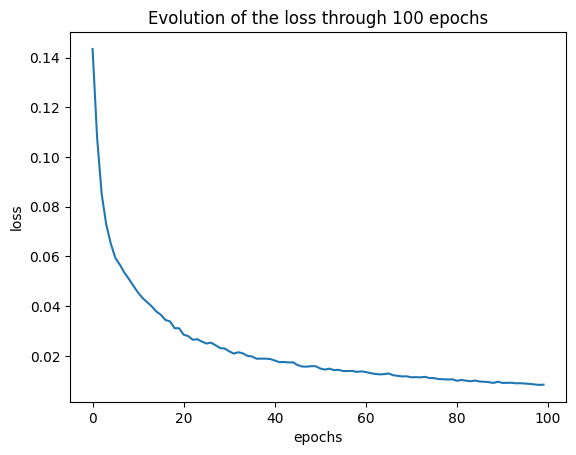

Final Loss: 0.008415445530956828


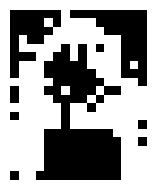

Image créée par le DBN


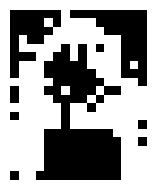


Test DBN avec q=100, n_layers=4, n_characters=3

Entraînement du DBN...


Going through epochs:   3%|▎         | 3/100 [00:00<00:04, 22.16it/s]

epoch 0/100 - loss : 0.16695391890930192


Going through epochs:  13%|█▎        | 13/100 [00:00<00:03, 25.93it/s]

epoch 10/100 - loss : 0.09400232683007752


Going through epochs:  22%|██▏       | 22/100 [00:00<00:03, 22.32it/s]

epoch 20/100 - loss : 0.07039405781799335


Going through epochs:  34%|███▍      | 34/100 [00:01<00:02, 22.18it/s]

epoch 30/100 - loss : 0.05550752211603411


Going through epochs:  43%|████▎     | 43/100 [00:01<00:02, 21.24it/s]

epoch 40/100 - loss : 0.044988378554342845


Going through epochs:  55%|█████▌    | 55/100 [00:02<00:02, 20.61it/s]

epoch 50/100 - loss : 0.03737785297952414


Going through epochs:  63%|██████▎   | 63/100 [00:02<00:02, 18.13it/s]

epoch 60/100 - loss : 0.03196425730897019


Going through epochs:  73%|███████▎  | 73/100 [00:03<00:01, 16.11it/s]

epoch 70/100 - loss : 0.026969596278875685


Going through epochs:  86%|████████▌ | 86/100 [00:04<00:00, 23.66it/s]

epoch 80/100 - loss : 0.02373661124965247


Going through epochs:  94%|█████████▍| 94/100 [00:04<00:00, 28.40it/s]

epoch 90/100 - loss : 0.020423961672498044


Going through epochs: 100%|██████████| 100/100 [00:04<00:00, 21.72it/s]


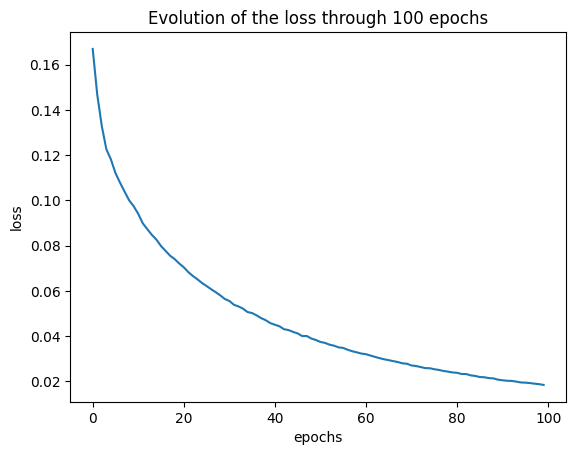

Final Loss: 0.018374158914650607


Going through epochs:  14%|█▍        | 14/100 [00:00<00:00, 135.21it/s]

epoch 0/100 - loss : 0.16639708099518613
epoch 10/100 - loss : 0.0727047410239922
epoch 20/100 - loss : 0.05350551926018096
epoch 30/100 - loss : 0.04307822000039286


Going through epochs:  69%|██████▉   | 69/100 [00:00<00:00, 169.13it/s]

epoch 40/100 - loss : 0.03485183459154831
epoch 50/100 - loss : 0.028899703948162683
epoch 60/100 - loss : 0.024051484391089017
epoch 70/100 - loss : 0.02067852353848543


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 168.60it/s]


epoch 80/100 - loss : 0.017195162479799474
epoch 90/100 - loss : 0.014382771918514952


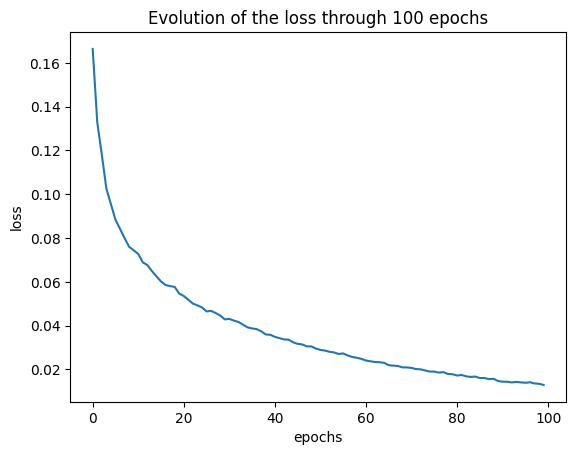

Final Loss: 0.012907102653160913


Going through epochs:  18%|█▊        | 18/100 [00:00<00:00, 179.41it/s]

epoch 0/100 - loss : 0.14137445579636546
epoch 10/100 - loss : 0.04518692392239526
epoch 20/100 - loss : 0.030686246074801908
epoch 30/100 - loss : 0.023662195992387745


Going through epochs:  60%|██████    | 60/100 [00:00<00:00, 196.27it/s]

epoch 40/100 - loss : 0.01887895601312245
epoch 50/100 - loss : 0.01575130225863204
epoch 60/100 - loss : 0.013179384070407375
epoch 70/100 - loss : 0.011868259954660943


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 189.95it/s]

epoch 80/100 - loss : 0.010393984132428341
epoch 90/100 - loss : 0.009814093423829941


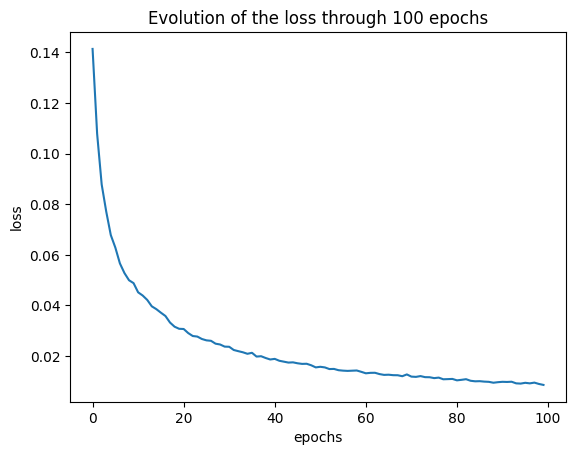

Final Loss: 0.008586535557674227


Going through epochs:  43%|████▎     | 43/100 [00:00<00:00, 210.22it/s]

epoch 0/100 - loss : 0.12476777182506836
epoch 10/100 - loss : 0.030886806671056963
epoch 20/100 - loss : 0.01728176724433503
epoch 30/100 - loss : 0.013074161300233911
epoch 40/100 - loss : 0.009738877665413821


Going through epochs:  86%|████████▌ | 86/100 [00:00<00:00, 203.58it/s]

epoch 50/100 - loss : 0.0085417506961859
epoch 60/100 - loss : 0.006615095018162663
epoch 70/100 - loss : 0.005970626807191766
epoch 80/100 - loss : 0.005913554866376342


Going through epochs: 100%|██████████| 100/100 [00:00<00:00, 204.79it/s]


epoch 90/100 - loss : 0.005189420472128278


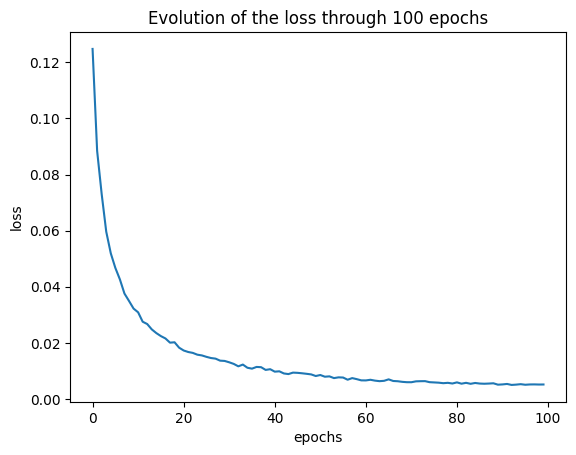

Final Loss: 0.005163373387606153


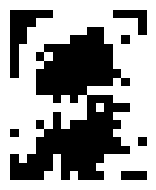

Image créée par le DBN


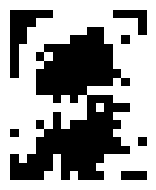


Test DBN avec q=400, n_layers=2, n_characters=3

Entraînement du DBN...


Going through epochs:   3%|▎         | 3/100 [00:00<00:03, 26.95it/s]

epoch 0/100 - loss : 0.14993838145124408


Going through epochs:  16%|█▌        | 16/100 [00:00<00:03, 26.27it/s]

epoch 10/100 - loss : 0.06117027197645124


Going through epochs:  25%|██▌       | 25/100 [00:00<00:02, 26.44it/s]

epoch 20/100 - loss : 0.03004807824991915


Going through epochs:  34%|███▍      | 34/100 [00:01<00:02, 26.07it/s]

epoch 30/100 - loss : 0.015984843033720875


Going through epochs:  43%|████▎     | 43/100 [00:01<00:02, 24.27it/s]

epoch 40/100 - loss : 0.008886658342196744


Going through epochs:  55%|█████▌    | 55/100 [00:02<00:01, 25.15it/s]

epoch 50/100 - loss : 0.0051467506309008735


Going through epochs:  64%|██████▍   | 64/100 [00:02<00:01, 20.53it/s]

epoch 60/100 - loss : 0.003430753704627979


Going through epochs:  73%|███████▎  | 73/100 [00:03<00:01, 15.19it/s]

epoch 70/100 - loss : 0.0022831305181118433


Going through epochs:  83%|████████▎ | 83/100 [00:03<00:01, 14.43it/s]

epoch 80/100 - loss : 0.001643269965127079


Going through epochs:  93%|█████████▎| 93/100 [00:04<00:00, 14.49it/s]

epoch 90/100 - loss : 0.001264090842668102


Going through epochs: 100%|██████████| 100/100 [00:05<00:00, 19.54it/s]


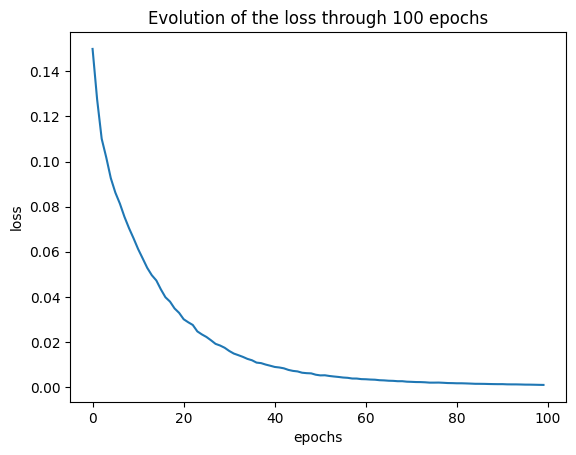

Final Loss: 0.0009171881254802887


Going through epochs:   2%|▏         | 2/100 [00:00<00:08, 11.98it/s]

epoch 0/100 - loss : 0.09411070136050312


Going through epochs:  12%|█▏        | 12/100 [00:00<00:07, 12.14it/s]

epoch 10/100 - loss : 0.029822288623817035


Going through epochs:  22%|██▏       | 22/100 [00:01<00:06, 11.81it/s]

epoch 20/100 - loss : 0.013921838488531225


Going through epochs:  32%|███▏      | 32/100 [00:02<00:06, 10.96it/s]

epoch 30/100 - loss : 0.007559279330073411


Going through epochs:  42%|████▏     | 42/100 [00:03<00:05, 10.12it/s]

epoch 40/100 - loss : 0.004687681503607114


Going through epochs:  52%|█████▏    | 52/100 [00:04<00:04, 10.67it/s]

epoch 50/100 - loss : 0.003216545491604831


Going through epochs:  62%|██████▏   | 62/100 [00:05<00:03, 10.50it/s]

epoch 60/100 - loss : 0.002414319061849366


Going through epochs:  72%|███████▏  | 72/100 [00:06<00:02, 10.68it/s]

epoch 70/100 - loss : 0.0019536481161412413


Going through epochs:  82%|████████▏ | 82/100 [00:07<00:01, 10.82it/s]

epoch 80/100 - loss : 0.0017126376907968847


Going through epochs:  92%|█████████▏| 92/100 [00:08<00:00, 11.31it/s]

epoch 90/100 - loss : 0.0013970654561271548


Going through epochs: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


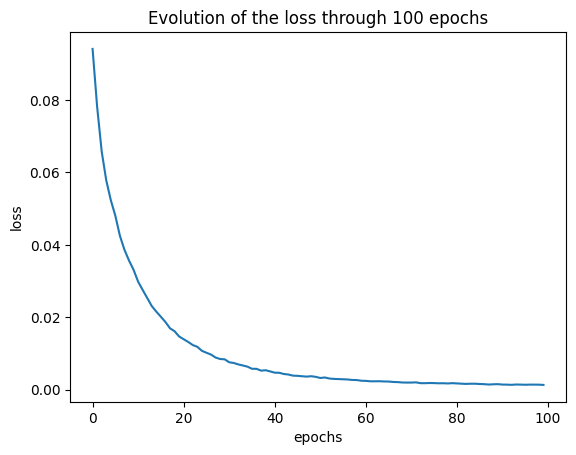

Final Loss: 0.0013009005243623023


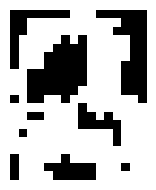

Image créée par le DBN


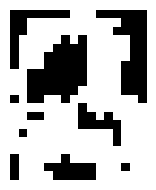


Test DBN avec q=400, n_layers=3, n_characters=3

Entraînement du DBN...


Going through epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0/100 - loss : 0.1516994507336364


Going through epochs:  15%|█▌        | 15/100 [00:00<00:02, 29.70it/s]

epoch 10/100 - loss : 0.06123887530293193


Going through epochs:  24%|██▍       | 24/100 [00:00<00:02, 25.55it/s]

epoch 20/100 - loss : 0.0312766847416419


Going through epochs:  33%|███▎      | 33/100 [00:01<00:02, 26.23it/s]

epoch 30/100 - loss : 0.01622013499734592


Going through epochs:  42%|████▏     | 42/100 [00:01<00:02, 25.92it/s]

epoch 40/100 - loss : 0.00864641387067069


Going through epochs:  52%|█████▏    | 52/100 [00:02<00:02, 19.41it/s]

epoch 50/100 - loss : 0.0052212483256089065


Going through epochs:  63%|██████▎   | 63/100 [00:02<00:02, 16.18it/s]

epoch 60/100 - loss : 0.0032103862830670554


Going through epochs:  73%|███████▎  | 73/100 [00:03<00:01, 15.18it/s]

epoch 70/100 - loss : 0.0024947604667307386


Going through epochs:  84%|████████▍ | 84/100 [00:04<00:00, 16.49it/s]

epoch 80/100 - loss : 0.0016621138370441944


Going through epochs:  92%|█████████▏| 92/100 [00:04<00:00, 15.25it/s]

epoch 90/100 - loss : 0.001097063063844575


Going through epochs: 100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


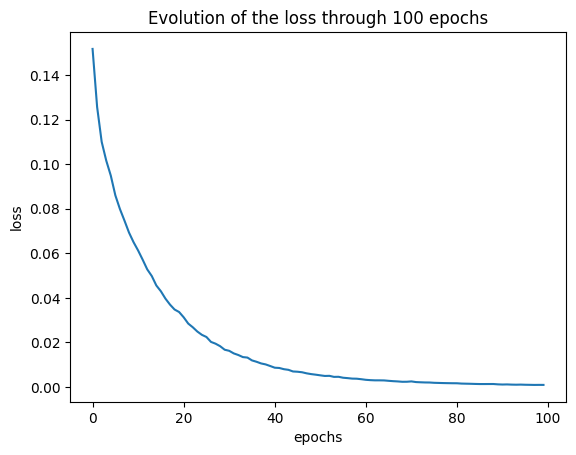

Final Loss: 0.0009261311551541408


Going through epochs:   1%|          | 1/100 [00:00<00:09,  9.97it/s]

epoch 0/100 - loss : 0.09397841949197419


Going through epochs:  13%|█▎        | 13/100 [00:01<00:07, 11.69it/s]

epoch 10/100 - loss : 0.030289494472767388


Going through epochs:  23%|██▎       | 23/100 [00:01<00:06, 11.89it/s]

epoch 20/100 - loss : 0.014285831330067368


Going through epochs:  33%|███▎      | 33/100 [00:02<00:05, 12.15it/s]

epoch 30/100 - loss : 0.007564904687462108


Going through epochs:  43%|████▎     | 43/100 [00:03<00:04, 11.98it/s]

epoch 40/100 - loss : 0.004583875436285697


Going through epochs:  53%|█████▎    | 53/100 [00:04<00:04, 11.68it/s]

epoch 50/100 - loss : 0.00330556163201106


Going through epochs:  63%|██████▎   | 63/100 [00:05<00:03, 11.73it/s]

epoch 60/100 - loss : 0.0023613320722815517


Going through epochs:  73%|███████▎  | 73/100 [00:06<00:02, 11.90it/s]

epoch 70/100 - loss : 0.0019205616662745632


Going through epochs:  83%|████████▎ | 83/100 [00:07<00:01, 11.79it/s]

epoch 80/100 - loss : 0.0017116439505314629


Going through epochs:  93%|█████████▎| 93/100 [00:07<00:00, 11.97it/s]

epoch 90/100 - loss : 0.0014354609076726369


Going through epochs: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


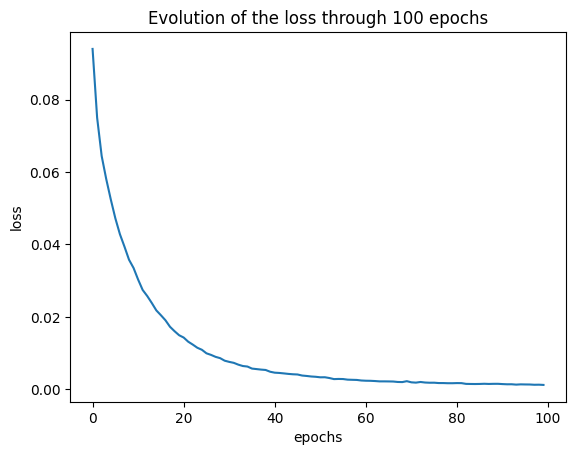

Final Loss: 0.0012032667074940127


Going through epochs:   1%|          | 1/100 [00:00<00:10,  9.85it/s]

epoch 0/100 - loss : 0.09642391540842109


Going through epochs:  13%|█▎        | 13/100 [00:01<00:07, 11.73it/s]

epoch 10/100 - loss : 0.029291703371016647


Going through epochs:  23%|██▎       | 23/100 [00:01<00:06, 11.96it/s]

epoch 20/100 - loss : 0.01432501929975472


Going through epochs:  33%|███▎      | 33/100 [00:02<00:05, 11.73it/s]

epoch 30/100 - loss : 0.008393012613058415


Going through epochs:  43%|████▎     | 43/100 [00:03<00:04, 11.88it/s]

epoch 40/100 - loss : 0.005646640073792056


Going through epochs:  53%|█████▎    | 53/100 [00:04<00:03, 11.79it/s]

epoch 50/100 - loss : 0.004115175380650552


Going through epochs:  63%|██████▎   | 63/100 [00:05<00:03, 12.27it/s]

epoch 60/100 - loss : 0.003238913443769482


Going through epochs:  73%|███████▎  | 73/100 [00:06<00:02, 12.09it/s]

epoch 70/100 - loss : 0.002743004639661586


Going through epochs:  83%|████████▎ | 83/100 [00:07<00:01, 12.00it/s]

epoch 80/100 - loss : 0.0023733420087133647


Going through epochs:  91%|█████████ | 91/100 [00:07<00:00, 12.10it/s]

epoch 90/100 - loss : 0.002169201247353454


Going through epochs: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


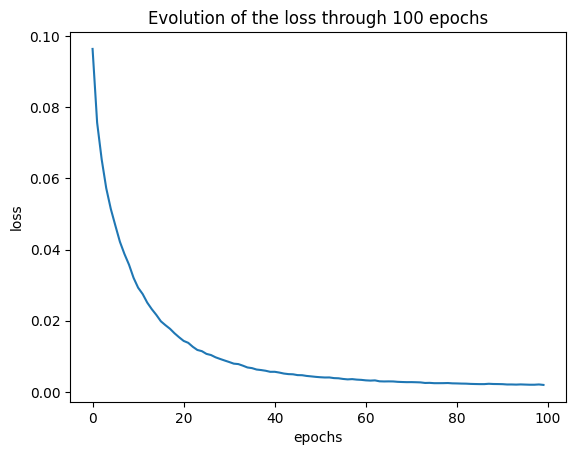

Final Loss: 0.0019545826749365384


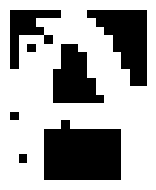

Image créée par le DBN


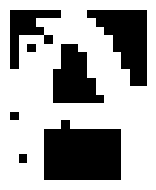


Test DBN avec q=400, n_layers=4, n_characters=3

Entraînement du DBN...


Going through epochs:   3%|▎         | 3/100 [00:00<00:04, 23.54it/s]

epoch 0/100 - loss : 0.1466767141051261


Going through epochs:  15%|█▌        | 15/100 [00:00<00:03, 26.10it/s]

epoch 10/100 - loss : 0.058082572574258376


Going through epochs:  24%|██▍       | 24/100 [00:00<00:02, 25.88it/s]

epoch 20/100 - loss : 0.029321325077175164


Going through epochs:  33%|███▎      | 33/100 [00:01<00:02, 23.36it/s]

epoch 30/100 - loss : 0.015014168092470963


Going through epochs:  42%|████▏     | 42/100 [00:01<00:02, 22.27it/s]

epoch 40/100 - loss : 0.00815481747728119


Going through epochs:  54%|█████▍    | 54/100 [00:02<00:02, 21.73it/s]

epoch 50/100 - loss : 0.005038976750184825


Going through epochs:  62%|██████▏   | 62/100 [00:02<00:02, 17.66it/s]

epoch 60/100 - loss : 0.0032305575182965964


Going through epochs:  72%|███████▏  | 72/100 [00:03<00:01, 14.28it/s]

epoch 70/100 - loss : 0.0021644966436088135


Going through epochs:  82%|████████▏ | 82/100 [00:04<00:01, 13.78it/s]

epoch 80/100 - loss : 0.001510431631187413


Going through epochs:  92%|█████████▏| 92/100 [00:04<00:00, 13.92it/s]

epoch 90/100 - loss : 0.0011374216474847024


Going through epochs: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


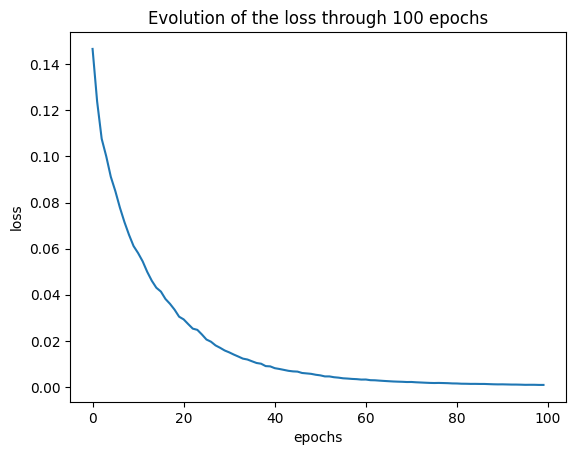

Final Loss: 0.0008872389255170482


Going through epochs:   1%|          | 1/100 [00:00<00:10,  9.14it/s]

epoch 0/100 - loss : 0.0924499848226919


Going through epochs:  13%|█▎        | 13/100 [00:01<00:06, 12.54it/s]

epoch 10/100 - loss : 0.029196594128375275


Going through epochs:  23%|██▎       | 23/100 [00:01<00:06, 12.68it/s]

epoch 20/100 - loss : 0.012949357891794907


Going through epochs:  33%|███▎      | 33/100 [00:02<00:05, 11.75it/s]

epoch 30/100 - loss : 0.0071479375516659786


Going through epochs:  43%|████▎     | 43/100 [00:03<00:04, 12.17it/s]

epoch 40/100 - loss : 0.004502378675700973


Going through epochs:  53%|█████▎    | 53/100 [00:04<00:04, 11.71it/s]

epoch 50/100 - loss : 0.003061729290807508


Going through epochs:  63%|██████▎   | 63/100 [00:05<00:03, 11.94it/s]

epoch 60/100 - loss : 0.0023535002887406092


Going through epochs:  73%|███████▎  | 73/100 [00:06<00:02, 11.75it/s]

epoch 70/100 - loss : 0.0017456539728385894


Going through epochs:  83%|████████▎ | 83/100 [00:06<00:01, 12.47it/s]

epoch 80/100 - loss : 0.001533384539862818


Going through epochs:  93%|█████████▎| 93/100 [00:07<00:00, 12.50it/s]

epoch 90/100 - loss : 0.001458815543644017


Going through epochs: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


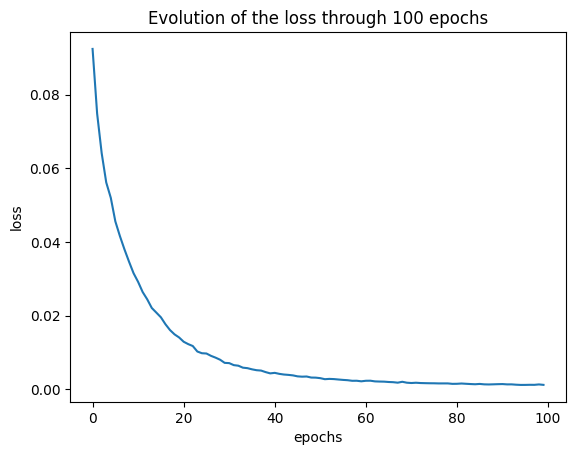

Final Loss: 0.001241488176397162


Going through epochs:   2%|▏         | 2/100 [00:00<00:06, 14.84it/s]

epoch 0/100 - loss : 0.09603536193192813


Going through epochs:  12%|█▏        | 12/100 [00:00<00:06, 12.90it/s]

epoch 10/100 - loss : 0.028896681869798296


Going through epochs:  22%|██▏       | 22/100 [00:01<00:06, 12.47it/s]

epoch 20/100 - loss : 0.01365323272030205


Going through epochs:  32%|███▏      | 32/100 [00:02<00:05, 12.36it/s]

epoch 30/100 - loss : 0.008015431442475785


Going through epochs:  42%|████▏     | 42/100 [00:03<00:04, 12.52it/s]

epoch 40/100 - loss : 0.0053582635119522526


Going through epochs:  52%|█████▏    | 52/100 [00:04<00:03, 12.16it/s]

epoch 50/100 - loss : 0.0038311715170233893


Going through epochs:  62%|██████▏   | 62/100 [00:04<00:03, 11.62it/s]

epoch 60/100 - loss : 0.002959543088159714


Going through epochs:  72%|███████▏  | 72/100 [00:05<00:02, 12.09it/s]

epoch 70/100 - loss : 0.002561289247047526


Going through epochs:  82%|████████▏ | 82/100 [00:06<00:01, 11.90it/s]

epoch 80/100 - loss : 0.0022105980218868307


Going through epochs:  92%|█████████▏| 92/100 [00:07<00:00, 11.41it/s]

epoch 90/100 - loss : 0.0019694651847327106


Going through epochs: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


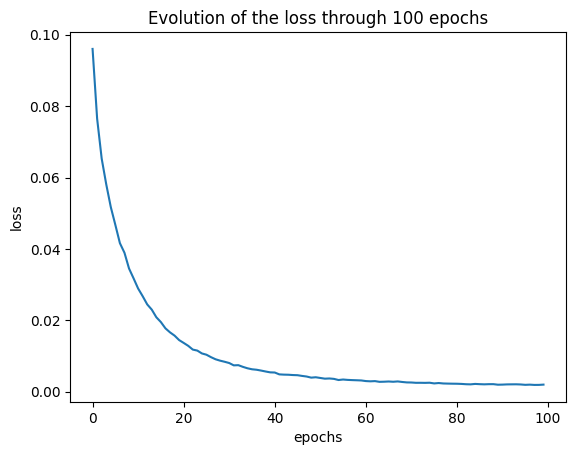

Final Loss: 0.0019666745179760803


Going through epochs:   2%|▏         | 2/100 [00:00<00:09, 10.44it/s]

epoch 0/100 - loss : 0.08172973843758473


Going through epochs:  12%|█▏        | 12/100 [00:00<00:07, 12.47it/s]

epoch 10/100 - loss : 0.02151769393521061


Going through epochs:  22%|██▏       | 22/100 [00:01<00:06, 12.25it/s]

epoch 20/100 - loss : 0.01014065211748087


Going through epochs:  32%|███▏      | 32/100 [00:02<00:05, 12.60it/s]

epoch 30/100 - loss : 0.005788646196770992


Going through epochs:  42%|████▏     | 42/100 [00:03<00:05, 11.60it/s]

epoch 40/100 - loss : 0.0035866316194951486


Going through epochs:  52%|█████▏    | 52/100 [00:04<00:04, 11.88it/s]

epoch 50/100 - loss : 0.002800536680658442


Going through epochs:  62%|██████▏   | 62/100 [00:05<00:03, 11.87it/s]

epoch 60/100 - loss : 0.0021387379012678008


Going through epochs:  72%|███████▏  | 72/100 [00:06<00:03,  8.84it/s]

epoch 70/100 - loss : 0.0017903778834720745


Going through epochs:  82%|████████▏ | 82/100 [00:07<00:01,  9.46it/s]

epoch 80/100 - loss : 0.0015513165614250261


Going through epochs:  92%|█████████▏| 92/100 [00:08<00:00,  9.29it/s]

epoch 90/100 - loss : 0.0014690549957869492


Going through epochs: 100%|██████████| 100/100 [00:09<00:00, 10.55it/s]


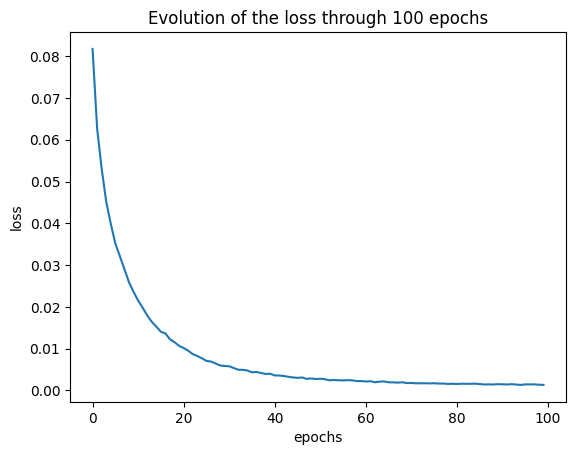

Final Loss: 0.0013258382559383057


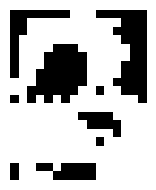

Image créée par le DBN


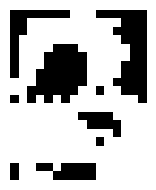


==> Tous les tests sont terminés.


In [5]:
# === PARAMÈTRES ===
hidden_units = [50, 100, 400]          # Nombre d'unités cachées
n_layers_list = [2, 3, 4]              # Nombre de couches pour DBN
n_characters_rbm = [2, 5, 7]           # Nombre de caractères pour RBM
n_characters_dbn = 3                   # Nombre de caractères pour DBN

lr = 0.01                               # Taux d'apprentissage
n_iter = 100                            # Nombre d'itérations
batch_size = 10                         # Taille des mini-batchs
iter_values = 200                       # Nombre d'itérations du sampleur

output_dir = "images_output"
os.makedirs(output_dir, exist_ok=True)

# === CHARGEMENT DES DONNÉES ===
data = scipy.io.loadmat('binaryalphadigs.mat')
size = data['dat'][0][0].shape

# === AFFICHAGE D'EXEMPLES D'IMAGES DE LA BASE DE DONNÉES ===
L = [10 + k for k in range(9)]  # Sélection de 9 caractères
X = lire_alpha_digit(data, L)

print("\nExemples d'images de la base de données :")
selected_images = [X[np.random.choice(X.shape[0])].reshape(size) for _ in range(9)]

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax, img in zip(axes.ravel(), selected_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()

# Sauvegarde de l'image des exemples de la base de données
plt.savefig(os.path.join(output_dir, 'exemples_base_alpha_digit.png'), dpi=300, bbox_inches='tight')
plt.show()

# === TEST RBM ===
for q in hidden_units:
    for n_characters in n_characters_rbm:
        print(f"\nTest RBM avec q={q}, n_characters={n_characters}")

        # Sélection des caractères
        L = [10 + k for k in range(n_characters)]
        X = lire_alpha_digit(data, L)

        # Crée un sous-dossier pour le jeu de paramètres
        test_dir = os.path.join(output_dir, f"rbm_q{q}_chars{n_characters}")
        os.makedirs(test_dir, exist_ok=True)

        # === ENTRAÎNEMENT RBM ===
        print("\nEntraînement du RBM...")
        rbm = RBM(p=X.shape[1], q=q)
        rbm.train_RBM(n_iter, lr, batch_size, X)

        # Génération d'une image avec le RBM
        generated_rbm_image = rbm.generate_images(nb_images=1, nb_iter=iter_values, size_img=size)[0]
        print("Image créée par le RBM")

        # Nom du fichier incluant les paramètres
        rbm_filename = f"generated_rbm_q{q}_chars{n_characters}.png"
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(generated_rbm_image, cmap='gray')
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(test_dir, rbm_filename), dpi=300, bbox_inches='tight')
        plt.show()

# === TEST DBN ===
for q in hidden_units:
    for n_layers in n_layers_list:
        print(f"\nTest DBN avec q={q}, n_layers={n_layers}, n_characters={n_characters_dbn}")

        # Sélection des caractères
        L = [10 + k for k in range(n_characters_dbn)]
        X = lire_alpha_digit(data, L)

        # Crée un sous-dossier pour le jeu de paramètres
        test_dir = os.path.join(output_dir, f"dbn_q{q}_layers{n_layers}_chars{n_characters_dbn}")
        os.makedirs(test_dir, exist_ok=True)

        # === ENTRAÎNEMENT DBN ===
        print("\nEntraînement du DBN...")
        dbn = DBN(p=X.shape[1], q=q, nb_layers=n_layers)
        dbn.train_DBN(n_iter, lr, batch_size, X)

        # Génération d'une image avec le DBN
        generated_dbn_image = dbn.generate_image_DBN(nb_iter=iter_values, nb_images=1, size_img=size)[0]
        print("Image créée par le DBN")

        # Nom du fichier incluant les paramètres
        dbn_filename = f"generated_dbn_q{q}_layers{n_layers}_chars{n_characters_dbn}.png"
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(generated_dbn_image, cmap='gray')
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(test_dir, dbn_filename), dpi=300, bbox_inches='tight')
        plt.show()

print("\n==> Tous les tests sont terminés.")

MNIST

In [ ]:
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Chargement des données MNIST
train_set = MNIST(root='./data', train=True, download=True)
test_set = MNIST(root='./data', train=False, download=True)

# Conversion des données en tableaux NumPy
train_mnist = train_set.data.numpy()
test_mnist = test_set.data.numpy()

# Binarisation des images
train_mnist = (train_mnist > 127)*1
test_mnist = (test_mnist > 127)*1

# Redimensionnement des données
train_mnist = train_mnist.reshape(train_mnist.shape[0], -1)
test_mnist = test_mnist.reshape(test_mnist.shape[0], -1)

# Nombre de classes
nb_classes = len(train_set.class_to_idx)

# Étiquettes
labels_train_mnist = train_set.targets.numpy()
labels_test_mnist = test_set.targets.numpy()

print("train_mnist shape : ", train_mnist.shape)
print("test_mnist shape : ", test_mnist.shape)
print("Number of classes : ", nb_classes)


In [ ]:
# Redimensionner les données d'entraînement
x_train = train_mnist.reshape((train_mnist.shape[0], -1))

# Encodage one-hot des étiquettes
y_train = np.zeros((train_mnist.shape[0], nb_classes))
y_train[np.arange(train_mnist.shape[0]), labels_train_mnist] = 1
y_train = y_train.reshape((y_train.shape[0], -1))

print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

# Redimensionner les données de test
x_test = test_mnist.reshape((test_mnist.shape[0], -1))

# Encodage one-hot des étiquettes de test
y_test = np.zeros((test_mnist.shape[0], nb_classes))
y_test[np.arange(test_mnist.shape[0]), labels_test_mnist] = 1
y_test = y_test.reshape((y_test.shape[0], -1))

print("x_test shape : ", x_test.shape)
print("y_test shape : ", y_test.shape)

# Concaténer les données d'entraînement et de test
x_traintest = np.concatenate([x_train, x_test], axis=0)
y_traintest = np.concatenate([y_train, y_test], axis=0)

print("x_traintest shape : ", x_traintest.shape)
print("y_traintest shape : ", y_traintest.shape)


In [ ]:
lr = 0.01
n_iter = 100
n_epochs = 200
batch_size = 10
list_nb_layers = [1, 2, 3, 4] 
nb_neurons = 200
nb_layers = 1
nb_pixels = x_train.shape[1]
res_dnn1 = []
res_dnn2 = []
for layer in list_nb_layers:
    Q = [nb_pixels] + [nb_neurons]*(nb_layers)
    dnn1 = DNN(Q, nb_layers=nb_layers)
    dnn2 = DNN(Q, nb_layers=nb_layers)
    dnn1.pretrain_DNN(n_iter, lr, batch_size, X=x_train)
    dnn1.retropropagation(n_iter, lr, batch_size, X=x_train, Y=y_train)
    dnn2.retropropagation(n_iter, lr, batch_size, X=x_train, Y=y_train)
    res_dnn1.append(dnn1.test_DNN(x_traintest, y_traintest))
    res_dnn2.append(dnn2.test_DNN(x_traintest, y_traintest))